# Import packages

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the image directory

 Remove corrupted images-If Jfif not in image header

# Train set

In [53]:
num_skipped = 0
for folder_name in ("cats", "dogs"):
    folder_path = os.path.join("D:/DS Training Videos/ML algo script/9.Neural Networks/Convolutional_Neural_Networks/training_set", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


# Test set

In [54]:
num_skipped = 0
for folder_name in ("cats", "dogs"):
    folder_path = os.path.join("D:/DS Training Videos/ML algo script/9.Neural Networks/Convolutional_Neural_Networks/test_set", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


# Create a Dataset

In [55]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Convolutional_Neural_Networks/training_set",
    validation_split=None,
    subset=None,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 8000 files belonging to 2 classes.


In [69]:
image_size = (256, 256)
batch_size = 32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Convolutional_Neural_Networks/test_set",
    validation_split=None,
    subset=None,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.


# Visualising the data

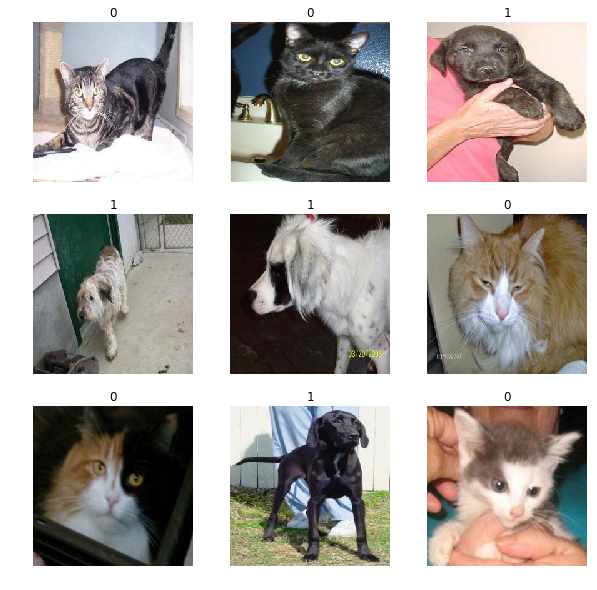

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data augmentation

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

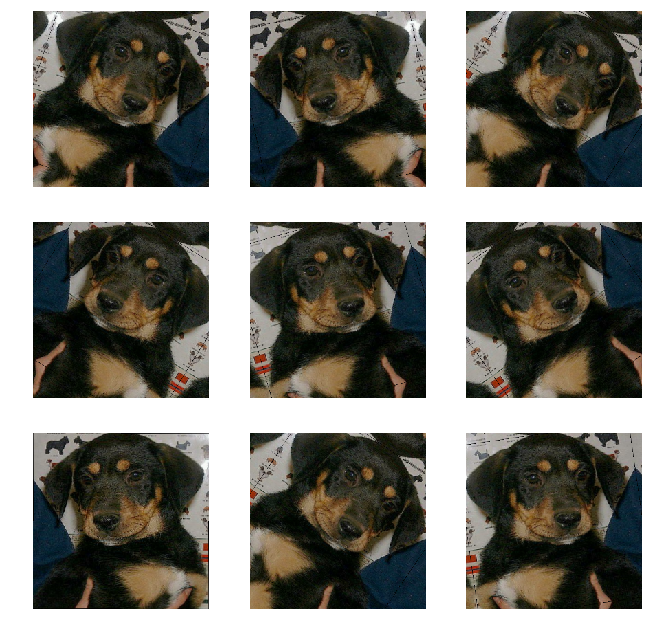

In [72]:
plt.figure(figsize=(11, 11))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Configure dataset for better performance

In [81]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build Model

In [90]:
num_classes=2
inputs = keras.Input(shape=(None,None,3))
    # Image augmentation block
x = data_augmentation(inputs)

    # Entry block
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
if num_classes == 2:
        activation = "sigmoid"
        units = 1
else:
        activation = "softmax"
        units = num_classes
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)
model= keras.Model(inputs, outputs)

In [91]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           sequential_1[6][0]               
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 3 896         rescaling_2[0][0]                
_______________________________________________________________________________________

batch_normalization_30 (BatchNo (None, None, None, 7 2912        separable_conv2d_24[0][0]        
__________________________________________________________________________________________________
activation_31 (Activation)      (None, None, None, 7 0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, None, None, 7 537264      activation_31[0][0]              
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, None, None, 7 2912        separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, None, None, 7 0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv2d_21 

# Train model

In [93]:
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/50


178/250 [====================>.........] - ETA: 0s - loss: 0.8286 - accuracy: 0.46 - ETA: 22:04 - loss: 0.7223 - accuracy: 0.546 - ETA: 29:03 - loss: 0.7627 - accuracy: 0.531 - ETA: 31:27 - loss: 0.7461 - accuracy: 0.585 - ETA: 32:45 - loss: 0.7379 - accuracy: 0.631 - ETA: 33:19 - loss: 0.7848 - accuracy: 0.625 - ETA: 34:01 - loss: 0.7896 - accuracy: 0.616 - ETA: 34:42 - loss: 0.7884 - accuracy: 0.601 - ETA: 34:59 - loss: 0.7767 - accuracy: 0.604 - ETA: 34:59 - loss: 0.7627 - accuracy: 0.603 - ETA: 34:57 - loss: 0.7506 - accuracy: 0.608 - ETA: 34:52 - loss: 0.7432 - accuracy: 0.609 - ETA: 34:45 - loss: 0.7470 - accuracy: 0.601 - ETA: 34:37 - loss: 0.7348 - accuracy: 0.604 - ETA: 34:31 - loss: 0.7292 - accuracy: 0.608 - ETA: 34:24 - loss: 0.7332 - accuracy: 0.603 - ETA: 34:16 - loss: 0.7238 - accuracy: 0.610 - ETA: 34:12 - loss: 0.7220 - accuracy: 0.605 - ETA: 34:06 - loss: 0.7311 - accuracy: 0.603 - ETA: 34:07 - loss: 0.7315 - accuracy: 0.604 - ETA: 34:17 - loss: 0.7373 - accuracy: 0.5

250/250 [==============================] - ETA: 14:35 - loss: 0.6994 - accuracy: 0.601 - ETA: 14:23 - loss: 0.6987 - accuracy: 0.602 - ETA: 14:11 - loss: 0.6978 - accuracy: 0.603 - ETA: 13:59 - loss: 0.6975 - accuracy: 0.603 - ETA: 13:47 - loss: 0.6972 - accuracy: 0.603 - ETA: 13:35 - loss: 0.6963 - accuracy: 0.604 - ETA: 13:23 - loss: 0.6970 - accuracy: 0.604 - ETA: 13:11 - loss: 0.6965 - accuracy: 0.604 - ETA: 12:59 - loss: 0.6961 - accuracy: 0.604 - ETA: 12:47 - loss: 0.6968 - accuracy: 0.604 - ETA: 12:35 - loss: 0.6970 - accuracy: 0.604 - ETA: 12:23 - loss: 0.6972 - accuracy: 0.604 - ETA: 12:12 - loss: 0.6962 - accuracy: 0.605 - ETA: 12:00 - loss: 0.6963 - accuracy: 0.605 - ETA: 11:48 - loss: 0.6956 - accuracy: 0.606 - ETA: 11:36 - loss: 0.6959 - accuracy: 0.606 - ETA: 11:23 - loss: 0.6956 - accuracy: 0.606 - ETA: 11:11 - loss: 0.6964 - accuracy: 0.606 - ETA: 10:59 - loss: 0.6962 - accuracy: 0.606 - ETA: 10:47 - loss: 0.6957 - accuracy: 0.606 - ETA: 10:35 - loss: 0.6962 - accuracy:

178/250 [====================>.........] - ETA: 0s - loss: 0.6001 - accuracy: 0.65 - ETA: 28:07 - loss: 0.5811 - accuracy: 0.718 - ETA: 36:59 - loss: 0.5685 - accuracy: 0.718 - ETA: 41:23 - loss: 0.5961 - accuracy: 0.671 - ETA: 44:08 - loss: 0.6119 - accuracy: 0.656 - ETA: 45:40 - loss: 0.6480 - accuracy: 0.635 - ETA: 46:54 - loss: 0.6420 - accuracy: 0.638 - ETA: 47:42 - loss: 0.6417 - accuracy: 0.636 - ETA: 48:25 - loss: 0.6397 - accuracy: 0.631 - ETA: 48:46 - loss: 0.6302 - accuracy: 0.628 - ETA: 49:02 - loss: 0.6273 - accuracy: 0.636 - ETA: 49:14 - loss: 0.6342 - accuracy: 0.625 - ETA: 49:21 - loss: 0.6276 - accuracy: 0.627 - ETA: 49:25 - loss: 0.6184 - accuracy: 0.638 - ETA: 49:27 - loss: 0.6203 - accuracy: 0.639 - ETA: 49:24 - loss: 0.6159 - accuracy: 0.642 - ETA: 49:20 - loss: 0.6165 - accuracy: 0.647 - ETA: 49:18 - loss: 0.6159 - accuracy: 0.647 - ETA: 49:25 - loss: 0.6216 - accuracy: 0.644 - ETA: 49:16 - loss: 0.6196 - accuracy: 0.648 - ETA: 49:05 - loss: 0.6125 - accuracy: 0.6

210/250 [========================>.....] - ETA: 16:30 - loss: 0.6197 - accuracy: 0.666 - ETA: 16:16 - loss: 0.6193 - accuracy: 0.667 - ETA: 16:02 - loss: 0.6188 - accuracy: 0.667 - ETA: 15:48 - loss: 0.6186 - accuracy: 0.666 - ETA: 15:34 - loss: 0.6183 - accuracy: 0.667 - ETA: 15:20 - loss: 0.6185 - accuracy: 0.666 - ETA: 15:05 - loss: 0.6185 - accuracy: 0.666 - ETA: 14:51 - loss: 0.6180 - accuracy: 0.666 - ETA: 14:37 - loss: 0.6171 - accuracy: 0.667 - ETA: 14:23 - loss: 0.6170 - accuracy: 0.667 - ETA: 14:09 - loss: 0.6173 - accuracy: 0.667 - ETA: 13:56 - loss: 0.6170 - accuracy: 0.667 - ETA: 13:41 - loss: 0.6177 - accuracy: 0.667 - ETA: 13:27 - loss: 0.6184 - accuracy: 0.666 - ETA: 13:13 - loss: 0.6180 - accuracy: 0.666 - ETA: 12:59 - loss: 0.6182 - accuracy: 0.666 - ETA: 12:45 - loss: 0.6180 - accuracy: 0.666 - ETA: 12:31 - loss: 0.6175 - accuracy: 0.667 - ETA: 12:17 - loss: 0.6172 - accuracy: 0.666 - ETA: 12:03 - loss: 0.6175 - accuracy: 0.666 - ETA: 11:49 - loss: 0.6178 - accuracy:

KeyboardInterrupt: 

# Prediction

In [94]:
img = keras.preprocessing.image.load_img(
    "Convolutional_Neural_Networks/test_set/cats/cat.4002.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 90.22 percent cat and 9.78 percent dog.
